In [1]:
import json 
import os
import tweepy

import plotly.express as px
import pandas as pd
from dotenv import load_dotenv

In [2]:
from datetime import date
import calendar

In [3]:
load_dotenv()

TWITTER_API_KEY = os.getenv("TWITTER_API_KEY")
TWITTER_API_SECRET = os.getenv("TWITTER_API_SECRET")
TWITTER_ACCESS_TOKEN = os.getenv("TWITTER_ACCESS_TOKEN")
TWITTER_ACCESS_TOKEN_SECRET = os.getenv("TWITTER_ACCESS_TOKEN_SECRET")

auth = tweepy.OAuthHandler(TWITTER_API_KEY, TWITTER_API_SECRET)
auth.set_access_token(TWITTER_ACCESS_TOKEN, TWITTER_ACCESS_TOKEN_SECRET)
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
chrisalbon_followers = api.followers_ids('chrisalbon')

In [24]:
class data_wrangling:
    """Performs the data wrangling required to find the content and times that the followers of the given twitter handle (specified as user_id parameter) engage with content, and the content they engage with. Used in the flask_app to give a response of the optimal time for the given twitteruser to post to optimize engagement."""
    # Definining api as a class variable (shared among all instances of the class) 
    api = tweepy.API(auth, wait_on_rate_limit=True)    
    
    def __init__(self, user_id, follower_count=10):
        # instance variables (unique for each instance of the class)
        self.user_id = user_id
        self.follower_count = follower_count

    def min_bin (mins):
        l = []
        for _min in mins:
            if _min < 30:
                l.append('00')
            else:
                l.append('30')

        return l
        
        
    # The first 10 ids of the user's followers
    def followers_ids(self):
        followers_ids = api.followers_ids(self.user_id)
        return followers_ids
    
    def get_follower_data(self, followers_ids):
        
        times = []
        text = []

        # Loop through the follower_count (int) defined in instance
        for followers in followers_ids[:self.follower_count]:

            # Try and excepts statement to bipass an error that arises when we call a protected user's information
            try:

                favorited_tweets = api.favorites(id=f'{followers}')

                # Fir each tweet that the follower liked, lets add it to the l string    
                for tweet in range(len(favorited_tweets)):

                    status = favorited_tweets[tweet]

                    #convert to string
                    json_str = json.dumps(status._json)

                    #deserialise string into python object
                    parsed = json.loads(json_str)
                    # gets the created_at (time) and the text from the tweets the followers liked
                    times.append(parsed.get('created_at'))
                    text.append(parsed.get('text'))

            except tweepy.TweepError:

                pass

        # seperates hours, mins into lists to be put into a df (leave hours as str to keep in military time for put request to backend)
        hours, mins = [i[11:13] for i in times], [int(i[14:16]) for i in times]
        
        _min_bin = data_wrangling.min_bin(mins)
         
        # creates df with times and text
        df = pd.DataFrame(data={'hours':hours, 'mins':mins, 'min_bin':_min_bin, 'text':text})
        
        df['time'] = df['hours'] + ':' + df['min_bin'].astype(str)
        
        return df
    
    def optimal_time(self, df):
        """This function finds the optimal time in 30 min bins, then returns it in UTC format"""
        
        #Today's date
        my_date = date.today()
        
        # Today's date reformatted for UTC
        day = my_date.strftime("%b %d %Y")
        
        # Day of week + day 
        day_and_date = calendar.day_name[my_date.weekday()][:3] + ' ' + day
        
        # Optimal time recommendation
        optimal_time = df['time'].value_counts().idxmax()
        
        # Example output: 'Tue Apr 21 2020 20:00:00 UTC+0000'
        return day_and_date + ' ' + optimal_time + ':00 UTC+0000'

In [14]:
dw = data_wrangling('LambdaSchool', 5)
fi = dw.followers_ids()
get_follower_data = dw.get_follower_data(fi)
dw.optimal_time(get_follower_data)

'Tue Apr 21 2020 00:30:00 UTC+0000'

In [25]:
data_wrangling.__doc__

'Performs the data wrangling required to find the content and times that the followers of the given twitter handle (specified as user_id parameter) engage with content, and the content they engage with. Used in the flask_app to give a response of the optimal time for the given twitteruser to post to optimize engagement.'

In [47]:
dw.optimal_time(get_follower_data)

'21:30'

In [41]:
military_time(get_follower_data['time'])

0     17:30
1     17:00
2     15:30
3     12:30
4      8:00
5      0:00
6      0:30
7     20:30
8     15:00
9     13:00
10    18:30
11    12:00
12     0:00
13    17:00
14    15:30
15    15:00
16    14:30
17    14:30
18    13:30
19    13:30
Name: time, dtype: object

In [8]:
get_follower_data.shape

(2873, 4)

In [7]:
get_follower_data.to_csv("get_follower_data.csv")

In [6]:
get_follower_data

,hours,mins,secs,text
0,16,30,36,How to UNPIVOT multiple columns into tidy pair...
1,16,0,4,"Shortest Path Algorithms, Part 2: Floyd�Warsha..."
2,15,8,1,Code to run SQL queries 10 times faster than B...
3,14,41,43,New to Data Visualization? Start with New York...
4,4,57,47,I wrote a Colab notebook that introduces diffe...
...,...,...,...,...
2868,20,37,35,"Potencialmente, el 20% de los trabajos pueden ..."
2869,18,57,25,No quieres instalar CoronApp por miedo a que t...
2870,15,58,9,@GomezJuan46 Primera Clase..
2871,12,57,33,"La economista jefe del FMI, Gita Gopinath, dec..."


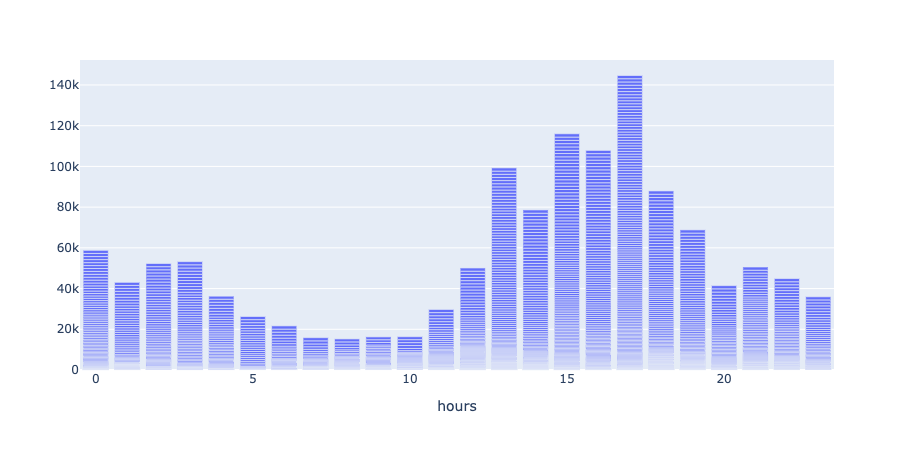

In [19]:
fig = px.bar(get_follower_data, x='hours')
fig.show()